Extracting VIIRS data (SNPP, L1 + L2) on the cloud for 2015/16 in the Amazon

In [2]:
import xarray as xr
import earthaccess
import datetime as dt
from pprint import pprint
import numpy as np
import pandas as pd
import time
import os
import fsspec
import geopandas as gpd
import rioxarray #needed for forest masking tiff
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

/projects/myenvs/candidates-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#source: https://forobs.jrc.ec.europa.eu/amazon
amazonia = gpd.read_file('/projects/shared-buckets/coffield/amazonia/amazonia_polygons.shp')
amazonia = amazonia.dissolve()
#amazonia.explore()

/tmp/ipykernel_23480/2039224114.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = amazonia.explode().reset_index(drop=True)
/tmp/ipykernel_23480/2039224114.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exploded.AREA = exploded.geometry.area


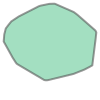

In [4]:
exploded = amazonia.explode().reset_index(drop=True)
exploded.AREA = exploded.geometry.area
#exploded.loc[0:1,:].explore()

geom = exploded.loc[0, 'geometry']
#geom = geom.simplify(0.4) #about 40km
geomc = geom.convex_hull
geomc

In [5]:
geom_string = str(geomc)[10:-2]
geom_string

'-63.43034744262695 -20.50092315673828, -63.767757415771484 -20.4754581451416, -63.88496017456055 -20.453052520751953, -64.2006607055664 -20.392698287963867, -74.12335968017578 -14.532249450683594, -74.5932388305664 -14.228923797607422, -74.72480773925781 -14.112621307373047, -75.06462860107422 -13.637988090515137, -76.19805145263672 -11.878687858581543, -79.47205352783203 -5.971370220184326, -79.59452819824219 -5.739683151245117, -79.59874725341797 -5.696430683135986, -79.56692504882812 -5.240001201629639, -79.37553405761719 -3.0267882347106934, -78.80882263183594 -0.7988593578338623, -78.71505737304688 -0.6551738381385803, -77.66124725341797 0.7232109904289246, -76.69065856933594 1.909584879875183, -76.65711975097656 1.9333646297454834, -73.87409973144531 3.7827863693237305, -66.3194580078125 7.6399993896484375, -65.66111755371094 7.877499580383301, -62.25083923339844 8.584165573120117, -62.232505798339844 8.586111068725586, -60.34788131713867 8.647115707397461, -60.34256362915039 8.

In [10]:
#for string for maap
'''
strings = [s.split(' ') for s in geom_string.split(',')]
strings2 = []
for i in strings:
    strings2.append([x for x in i if x])
stop

strings2 = [','.join(k) for k in strings2]
strings2 = strings2[::-1]
strings3 = ','.join(strings2)
'''

"\nstrings = [s.split(' ') for s in geom_string.split(',')]\nstrings2 = []\nfor i in strings:\n    strings2.append([x for x in i if x])\nstop\n\nstrings2 = [','.join(k) for k in strings2]\nstrings2 = strings2[::-1]\nstrings3 = ','.join(strings2)\n"

In [5]:
#for list of tuples for earthaccess
strings = [s.split(' ') for s in geom_string.split(',')]
strings2 = []
for i in strings:
    strings2.append([x for x in i if x])

for i in range(len(strings2)):
    strings2[i] = [np.round(float(j),4) for j in strings2[i]]
tuples = strings2[::-1]
tuples[:10]

[[-63.4303, -20.5009],
 [-62.9783, -20.4755],
 [-62.8128, -20.4564],
 [-53.0075, -18.0665],
 [-48.9169, -16.4386],
 [-47.0239, -15.4608],
 [-45.9523, -14.8683],
 [-45.8789, -14.8091],
 [-45.8755, -14.7857],
 [-44.6164, -4.7414]]

In [12]:
'''
results = maap.searchGranule(
    short_name='VNP14IMG',
    cmr_host='cmr.earthdata.nasa.gov',
    temporal='2020-09-05T00:00:00Z,2020-09-07T23:59:59Z',
    polygon = ,
    limit=10)
print(f'Got {len(results)} results')
'''

"\nresults = maap.searchGranule(\n    short_name='VNP14IMG',\n    cmr_host='cmr.earthdata.nasa.gov',\n    temporal='2020-09-05T00:00:00Z,2020-09-07T23:59:59Z',\n    polygon = ,\n    limit=10)\nprint(f'Got {len(results)} results')\n"

In [6]:
earthaccess.login(strategy='netrc') #for LAADS access - every hour
s3_fsspec = fsspec.filesystem("s3", profile="maap-data-reader") #for direct reader access to LPDAAC

In [11]:
#testing, optional
results = earthaccess.search_data(
    short_name='VNP14IMG',
    polygon=tuples,
    temporal=('2015-11-01', '2015-12-01'),
    count=50)
#files[products[sat][0]] = earthaccess.open(results)

urls = [r.data_links(access='direct')[0] for r in results]
files = [s3_fsspec.open(url) for url in urls]
pprint(files[:5])

xr.open_dataset(files[0], phony_dims='sort')

Granules found: 314
[<File-like object S3FileSystem, lp-prod-protected/VNP14IMG.002/VNP14IMG.A2015305.0454.002.2024068004333/VNP14IMG.A2015305.0454.002.2024068004333.nc>,
 <File-like object S3FileSystem, lp-prod-protected/VNP14IMG.002/VNP14IMG.A2015305.0500.002.2024068004326/VNP14IMG.A2015305.0500.002.2024068004326.nc>,
 <File-like object S3FileSystem, lp-prod-protected/VNP14IMG.002/VNP14IMG.A2015305.0636.002.2024068004328/VNP14IMG.A2015305.0636.002.2024068004328.nc>,
 <File-like object S3FileSystem, lp-prod-protected/VNP14IMG.002/VNP14IMG.A2015305.0642.002.2024068004323/VNP14IMG.A2015305.0642.002.2024068004323.nc>,
 <File-like object S3FileSystem, lp-prod-protected/VNP14IMG.002/VNP14IMG.A2015305.1554.002.2024068004333/VNP14IMG.A2015305.1554.002.2024068004333.nc>]


<xarray.Dataset>
Dimensions:        (phony_dim_0: 554, phony_dim_1: 6496, phony_dim_2: 6400)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables: (12/26)
    FP_AdjCloud    (phony_dim_0) uint16 ...
    FP_AdjWater    (phony_dim_0) uint16 ...
    FP_MAD_DT      (phony_dim_0) float32 ...
    FP_MAD_T4      (phony_dim_0) float32 ...
    FP_MAD_T5      (phony_dim_0) float32 ...
    FP_MeanDT      (phony_dim_0) float32 ...
    ...             ...
    FP_line        (phony_dim_0) uint16 ...
    FP_longitude   (phony_dim_0) float32 ...
    FP_power       (phony_dim_0) float32 ...
    FP_sample      (phony_dim_0) uint16 ...
    algorithm QA   (phony_dim_1, phony_dim_2) uint32 ...
    fire mask      (phony_dim_1, phony_dim_2) uint8 ...
Attributes: (12/70)
    AlgorithmType:                     OPS
    AlgorithmVersion:                  NPP_PR14IMG 3.1.6
    CloudPix:                          8441312
    Conventions:                       CF-1.6
    Day/Night/Both:                    Night
    DayNightFlag:                      Night
    ...                                ...
    project:                           VIIRS Land SIPS Active Fire
    publisher_email:                   modis-ops@lists.nasa.gov
    publisher_name:                    LAADS
    publisher_url:                     https://ladsweb.modaps.eosdis.nasa.gov
    stdname_vocabulary:                NetCDF Climate and Forecast (CF) Metad...
    title:                             VIIRS 375m Active Fire Data

In [84]:
pd.to_datetime('2024/08/13').strftime('%j')

'226'

In [6]:
extent = geomc.bounds

start = dt.date(2015,9,1)

months = [start + pd.DateOffset(months=i) for i in range(9)]
months

[Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2015-12-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-02-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-04-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00')]

In [8]:
def fetch_data():
    
    files = {}

    earthaccess.login(strategy='netrc') #for LAADS access - every hour

    #Level1 data from LAADS ------
    #geolocation 03IMG
    results = earthaccess.search_data(
        short_name=products[0],
        polygon=tuples,
        temporal=(start, end),
        count=800)
    files[products[0]] = earthaccess.open(results)
    '''
    #science data 02IMG
    results = earthaccess.search_data(
        short_name=products[1],
        polygon=tuples,
        temporal=(start, end),
        count=800)
    files[products[1]] = earthaccess.open(results)
    '''
    #Level2 data 14IMG
    results = earthaccess.search_data(
        short_name=products[2],
        polygon=tuples,
        temporal=(start, end),
        count=800)     
    urls = [r.data_links(access='direct')[0] for r in results]
    files[products[2]] = [s3_fsspec.open(url) for url in urls]
    
    return files

In [9]:
def extract_fires(start, end, sat, products, files, auth_time):
    
    all_dets = pd.DataFrame() #list of all known+candidate detections per satellite

    for i in range(len( files[products[0]] )): #VNP03IMG or VJ103IMG
        
        elapsed = (time.time() - auth_time ) / 60 #reauthenticate hourly as needed
        if elapsed > 56:
            print('reauthenticating')
            files = fetch_data()
            auth_time = time.time()
        
        timestamp = files[products[0]][i].path.split('.')[-5:-3]
        print(timestamp)
        year = timestamp[0][1:5]
        day = timestamp[0][5:8]
        timee = timestamp[1]
        date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %-d') 
        acq_datetime = dt.datetime.strptime(year+day+timee[:2]+timee[2:], '%Y%j%H%M').strftime('%Y-%m-%d %H:%M:00 +00:00') 
        #daytime = int(time) > 1500 #depends on timezone

        try:
            #open 03IMG geolocation
            geo = xr.open_dataset(files[products[0]][i], engine='h5netcdf', group='geolocation_data')
            lon = geo['longitude'][:]
            lat = geo['latitude'][:]
            _, j = np.indices(geo.longitude.shape) #line and sample
            
            scene = (lon > extent[0]) & (lon < extent[2]) & (lat > extent[1]) & (lat < extent[3])
            
            #crop down the datasets for memory 
            indices = np.where(scene)
            if len(indices[0])==0 or len(indices[1])==0: print('no data in scene')
            x0 = indices[0].min()
            x1 = indices[0].max()
            y0 = indices[1].min()
            y1 = indices[1].max()

            lon = lon[x0:x1, y0:y1]
            lat = lat[x0:x1, y0:y1]
            j = j[x0:x1, y0:y1]

            if lon.size==0: continue #skip ahead
            
            #open 02IMG science data, i4 band - UNNECESSARY?
            '''
            data = xr.open_dataset(files[products[1]][i], engine='h5netcdf', group='observation_data')
            data = data.sel(number_of_lines=slice(x0,x1), number_of_pixels=slice(y0,y1))

            i4 = data['I04'] #xarray already encodes the scale factor and offset
            scale = data.I04.encoding['scale_factor']
            offset = data.I04.encoding['add_offset']
            i4 = (i4[:,:] - offset) / scale #return to raw values to use lookup table to temperature
            i4 = i4.astype(int)
            i4_bt = data['I04_brightness_temperature_lut'][:]
            i4_bt = i4_bt[i4]
            '''
            #get VNP14IMG
            match = [f for f in files[products[2]] if '.'.join([timestamp[0],timestamp[1]]) in str(f)][0]
            data = xr.open_dataset(match, phony_dims='sort')
            data = data.sel(phony_dim_1=slice(x0,x1), phony_dim_2=slice(y0,y1))

            daynight = data.DayNightFlag #string Day or Night

            qa = data.variables['algorithm QA'][:]
            fire = data.variables['fire mask'][:]  
            fires = (fire>6).values

        except:
            print('error with file or does not exist',timestamp)
            continue


        #look at QA flags data next over entire scene
        values, counts = np.unique(qa, return_counts=True)

        table = pd.DataFrame(index = values, columns=range(22,-1,-1)) #[22,21,...0]
        for i1 in table.index:
            b = np.binary_repr(i1, width=23)
            b = [int(s) for s in b]
            table.loc[i1, :] = b

        #report back all the pixels that have an 8 or 10 ~ background or candidate fires
        keep = table[(table.loc[:,8]==1) | (table.loc[:,10]==1)].index
        keep = (np.isin(qa[:], keep) | (fires))  #"fires" because some low conf are Test 16 pixel saturation

        if keep.sum()==0:
            print('no dets')
            continue #skip ahead if no detections
        
        #build pandas table for exporting, following VIIRS L2 columns
        i_dets = pd.DataFrame()
        i_dets['longitude'] = list(lon.values[keep])
        i_dets['latitude'] = list(lat.values[keep])
        i_dets['fire_mask'] = list(fire.values[keep])
        i_dets['daynight'] = daynight[0]
        i_dets['confidence'] = i_dets.fire_mask
        i_dets.confidence = i_dets.confidence.replace({0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
        i_dets['acq_date'] = day
        #i_dets['acq_date'] = dt.datetime.strptime(year+day, '%Y%j').strftime('%Y/%m/%d') 
        i_dets['acq_time'] = timee
        i_dets['acq_datetime'] = acq_datetime
        i_dets['j'] = list(j[keep]) #sample number for pixel size lookup

        i_dets = i_dets[i_dets.fire_mask>4] #remove non-land candidates
        
        #crop down to defined extent
        i_dets = i_dets[(i_dets.longitude > extent[0]) & (i_dets.longitude < extent[2]) & (i_dets.latitude > extent[1]) & (i_dets.latitude < extent[3])]

        all_dets = pd.concat([all_dets, i_dets])

        del geo, scene, lon, lat, i_dets #, data, i4
     
    all_dets.to_csv(f'/projects/my-public-bucket/viirs/outputs/amazon/{months[m].strftime("%Y_%m")}_detections_{sat}.csv', index=False)
    
    return all_dets


In [10]:
%%time 
#quite slow, about an hour per month for full amazonia extraction

for m in range(len(months)-1):
    start = months[m].strftime('%Y-%m-%d') 
    end = months[m+1].strftime('%Y-%m-%d') 
    print(start, '--------------------------------')
    
    sat = 'SNPP'
    products = ['VNP03IMG','VNP02IMG','VNP14IMG']

    #FETCH CLOUD SWATHS -----------------
    files = fetch_data()
    auth_time = time.time()

    #pprint(files)
    
    
    #EXTRACT FIRE PIXELS -------------------------------------
    all_dets = extract_fires(start, end, sat, products, files, auth_time)
    
    del files

print('done')

2015-11-01 --------------------------------
Granules found: 314
Opening 314 granules, approx size: 48.07 GB
using provider: LAADS


QUEUEING TASKS | : 314it [00:00, 3522.20it/s]
PROCESSING TASKS | : 100%|██████████| 314/314 [00:01<00:00, 287.68it/s]
COLLECTING RESULTS | : 100%|██████████| 314/314 [00:00<00:00, 501718.65it/s]


Granules found: 314
['A2015305', '0454']
['A2015305', '0500']
['A2015305', '0636']
['A2015305', '0642']
['A2015305', '1554']
['A2015305', '1600']
['A2015305', '1730']
['A2015305', '1736']
['A2015305', '1742']
['A2015305', '1912']
['A2015305', '1918']
['A2015306', '0436']
['A2015306', '0442']
['A2015306', '0618']
['A2015306', '0624']
['A2015306', '1536']
['A2015306', '1712']
['A2015306', '1718']
['A2015306', '1854']
['A2015306', '1900']
['A2015307', '0418']
['A2015307', '0424']
['A2015307', '0554']
['A2015307', '0600']
['A2015307', '0606']
['A2015307', '1654']
['A2015307', '1700']
['A2015307', '1836']
['A2015307', '1842']
['A2015308', '0400']
['A2015308', '0406']
['A2015308', '0536']
['A2015308', '0542']
['A2015308', '0548']
['A2015308', '0718']
['A2015308', '0724']
['A2015308', '1636']
['A2015308', '1642']
['A2015308', '1818']
['A2015308', '1824']
['A2015309', '0342']
['A2015309', '0348']
['A2015309', '0518']
['A2015309', '0524']
['A2015309', '0700']
['A2015309', '0706']
['A2015309', '

QUEUEING TASKS | : 314it [00:00, 21440.27it/s]
PROCESSING TASKS | : 100%|██████████| 314/314 [00:02<00:00, 139.19it/s]
COLLECTING RESULTS | : 100%|██████████| 314/314 [00:00<00:00, 529984.49it/s]


Granules found: 314
['A2015324', '1642']
['A2015324', '1818']
['A2015324', '1824']
['A2015325', '0342']
['A2015325', '0348']
['A2015325', '0518']
['A2015325', '0524']
['A2015325', '0700']
['A2015325', '0706']
['A2015325', '1618']
['A2015325', '1624']
['A2015325', '1754']
['A2015325', '1800']
['A2015325', '1806']
['A2015325', '1942']
['A2015326', '0324']
['A2015326', '0500']
['A2015326', '0506']
['A2015326', '0642']
['A2015326', '0648']
['A2015326', '1600']
['A2015326', '1606']
['A2015326', '1736']
['A2015326', '1742']
['A2015326', '1748']
['A2015326', '1918']
['A2015326', '1924']
['A2015327', '0442']
['A2015327', '0448']
['A2015327', '0624']
['A2015327', '0630']
['A2015327', '1542']
['A2015327', '1718']
['A2015327', '1724']
['A2015327', '1900']
['A2015327', '1906']
['A2015328', '0424']
['A2015328', '0430']
['A2015328', '0600']
['A2015328', '0606']
['A2015328', '0612']
['A2015328', '1700']
['A2015328', '1706']
['A2015328', '1842']
['A2015328', '1848']
['A2015329', '0406']
['A2015329', '

<h4>Read in forest mask derived from Mapbiomas Amazonia

In [8]:
forest = rioxarray.open_rasterio(f'/projects/shared-buckets/coffield/mapbiomas2015_mask.tif')[0,:,:]
forest

<xarray.DataArray (y: 7144, x: 8437)>
[60273928 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 -80.5 -80.5 -80.5 -80.49 ... -42.62 -42.62 -42.61
  * y            (y) float64 10.92 10.91 10.91 10.9 ... -21.16 -21.16 -21.17
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      remapped

^This comes from Mapbiomas Amazonia LULC via Google Earth Engine, reprojected to 500m. Forest cover classes "Forest","Natural Forest", "Forest Formation" are combined as a forest mask (excluding savanna, mangroves, and flooded forest). Mask is reprojected to 500m using the mode, such that pixels with >50% forest have value 1 and others 0. Alternatively the 'mapbiomas2015.tif' file is the full set of classes at 500m (not binary). See mapbiomas GEE script for details:
https://code.earthengine.google.com/?accept_repo=users/coffield/fires 

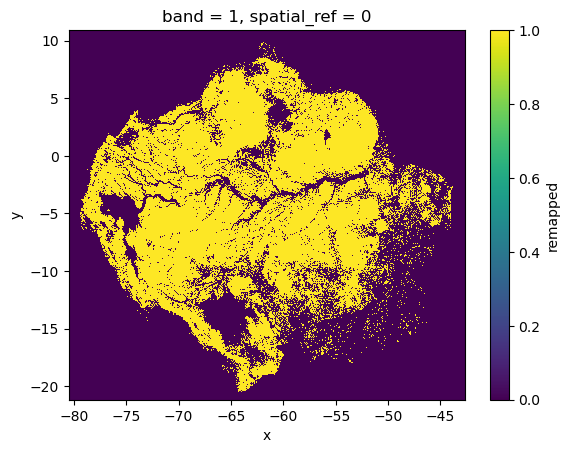

In [25]:
forest.plot()

<h4>Clip to Amazonia and add column for forest yes/no

In [9]:
%%time

for m in months[:-1]:
    print(m)
    viirs = pd.read_csv(f'/projects/shared-buckets/coffield/viirs/outputs/amazon/{m.strftime("%Y_%m")}_detections_SNPP.csv')
    viirs = gpd.GeoDataFrame(viirs, geometry=gpd.GeoSeries.from_xy(viirs['longitude'], viirs['latitude']), crs=4326)
    
    #clip to amazonia
    viirs = viirs.clip(geomc)

    #get corresponding lulc from mapbiomas
    x = viirs.longitude.to_xarray()
    y = viirs.latitude.to_xarray()
    viirs['forest'] = forest.sel(x=x, y=y, method='nearest').data
    
    #save a version with "forest" 0 or 1 column
    viirs.to_csv(f'/projects/my-public-bucket/viirs/outputs/amazon/{m.strftime("%Y_%m")}_detections_SNPP.csv', index=False)

2015-11-01 00:00:00
CPU times: user 9.74 s, sys: 282 ms, total: 10 s
Wall time: 11.2 s


<h4>Mask to forests only and add column for passing spatial-temporal filter yes/no

In [ ]:
%%time
#about 9 minutes per month to do spatial/temporal filtering :(

for m in months[:-1]:    
    print(m)
    viirs = pd.read_csv(f'/projects/shared-buckets/coffield/viirs/outputs/amazon/{m.strftime("%Y_%m")}_detections_SNPP_clipped.csv')

    #filter in space & time: within 4km (0.04 deg) and 4 days of a known fire detection
    
    #need adjacent months included:
    prev_month = m - pd.DateOffset(months=1)
    prev_month = f'/projects/shared-buckets/coffield/viirs/outputs/amazon/{prev_month.strftime("%Y_%m")}_detections_SNPP.csv'
    next_month = m + pd.DateOffset(months=1)
    next_month = f'/projects/shared-buckets/coffield/viirs/outputs/amazon/{next_month.strftime("%Y_%m")}_detections_SNPP.csv'

    if os.path.exists(prev_month):
        print('getting end of previous month')
        adj_dets = pd.read_csv(prev_month)
        last_day = adj_dets.acq_date.max()
        adj_dets = adj_dets[adj_dets.acq_date >= last_day - 4]
        viirs = pd.concat([adj_dets, viirs])
    
    if os.path.exists(next_month):
        print('getting beginning of following month')
        adj_dets = pd.read_csv(next_month)
        first_day = adj_dets.acq_date.min()
        adj_dets = adj_dets[adj_dets.acq_date <= first_day + 4]
        viirs = pd.concat([viirs, adj_dets])
    
    
    #mask to forest only
    viirs = viirs[viirs.forest==1] 
    
    viirs.acq_datetime = pd.to_datetime(viirs.acq_datetime)
    
    known = viirs[viirs.fire_mask>6]

    #loop through all candidates for current month of interest (slow)
    for i in viirs[(viirs.fire_mask<7) & (viirs.acq_datetime.dt.month==m.month)].index: 
        lon = viirs.loc[i, 'longitude']
        lat = viirs.loc[i, 'latitude']
        t = viirs.loc[i, 'acq_datetime']
        nearby = ((np.abs(known.longitude-lon)<0.04) & (np.abs(known.latitude-lat)<0.04) & (np.abs(known.acq_datetime-t)<dt.timedelta(4))) .sum()
        viirs.loc[i, 'pass_filter'] = nearby>0
        
     
    viirs = viirs[viirs.acq_datetime.dt.month == m.month] #clip back down to this month only
    
    #viirs = viirs[(viirs.pass_filter==True) | (viirs.fire_mask>6)] #save only passed pixels
    
    #export
    viirs.to_csv(f'/projects/my-public-bucket/viirs/outputs/amazon/{m.strftime("%Y_%m")}_detections_SNPP_masked_filter.csv', index=False)
    
print('done')

2015-11-01 00:00:00
getting end of previous month
getting beginning of following month


<h4>See other notebook "amazon_combined_plots" for plotting with lonboard

<h4>Old stuff - Demonstrating land cover types and masking:</h4>
(when viirs dataframe had a "cover" column)

In [37]:
palette = ["#ffffff", #from GEE mapbiomas script
  "#32a65e",
  "#32a65e",
  "#1f8d49",
  "#7dc975",
  "#04381d",
  "#026975",
  "#000000",
  "#000000",
  "#7a6c00",
  "#ad975a",
  "#519799",
  "#d6bc74",
  "#d89f5c",
  "#FFFFB2",
  "#edde8e",
  "#000000",
  "#000000",
  "#f5b3c8",
  "#C27BA0",
  "#db7093",
  "#ffefc3",
  "#db4d4f",
  "#ffa07a",
  "#d4271e",
  "#db4d4f",
  "#0000FF",
  "#000000",
  "#000000",
  "#ffaa5f",
  "#9c0027",
  "#091077",
  "#fc8114",
  "#2532e4",
  "#93dfe6",
  "#9065d0",
  "#d082de",
  "#000000",
  "#000000",
  "#f5b3c8",
  "#c71585",
  "#f54ca9",
  "#cca0d4",
  "#dbd26b",
  "#807a40",
  "#e04cfa",
  "#d68fe2",
  "#9932cc",
  "#e6ccff",
  "#02d659",
  "#ad5100",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#000000",
  "#CC66FF",
  "#FF6666",
  "#006400",
  "#8d9e8b",
  "#f5d5d5",
  "#ff69b4"]

In [42]:
viirs['color'] = [palette[i] for i in viirs.cover]
viirs

/projects/myenvs/candidates-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,longitude,latitude,fire_mask,daynight,confidence,acq_date,acq_time,acq_datetime,j,geometry,cover,color
409067,-49.502537,-16.663818,8.0,D,n,260,1636,2015-09-17 16:36:00 +00:00,4292.0,POINT (-49.50254 -16.66382),0,#ffffff
673329,-49.521698,-16.648539,7.0,D,l,269,1706,2015-09-26 17:06:00 +00:00,2364.0,POINT (-49.52170 -16.64854),0,#ffffff
673330,-49.520737,-16.648447,8.0,D,n,269,1706,2015-09-26 17:06:00 +00:00,2362.0,POINT (-49.52074 -16.64845),0,#ffffff
712768,-49.480156,-16.637068,8.0,D,n,270,1648,2015-09-27 16:48:00 +00:00,3561.0,POINT (-49.48016 -16.63707),0,#ffffff
543131,-49.408836,-16.627094,5.0,D,x,264,1700,2015-09-21 17:00:00 +00:00,2710.0,POINT (-49.40884 -16.62709),0,#ffffff
...,...,...,...,...,...,...,...,...,...,...,...,...
12026,-63.862316,8.040121,5.0,N,x,245,518,2015-09-02 05:18:00 +00:00,1591.0,POINT (-63.86232 8.04012),33,#2532e4
106533,-63.861030,8.040983,5.0,N,x,250,524,2015-09-07 05:24:00 +00:00,1975.0,POINT (-63.86103 8.04098),33,#2532e4
258087,-63.862350,8.041030,5.0,N,x,255,530,2015-09-12 05:30:00 +00:00,2308.0,POINT (-63.86235 8.04103),33,#2532e4
258083,-63.861790,8.044704,5.0,N,x,255,530,2015-09-12 05:30:00 +00:00,2308.0,POINT (-63.86179 8.04470),33,#2532e4


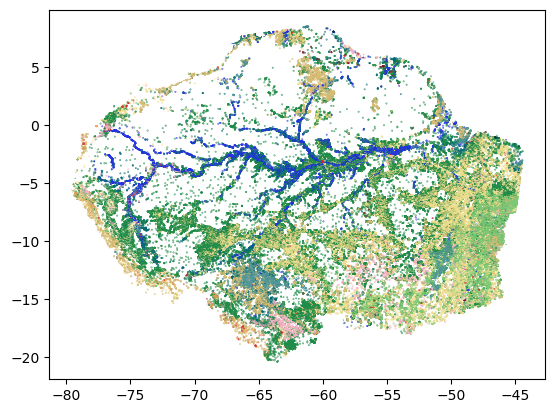

In [43]:
import matplotlib.pyplot as plt
plt.scatter(viirs.longitude, viirs.latitude, c=viirs.color, s=0.1)

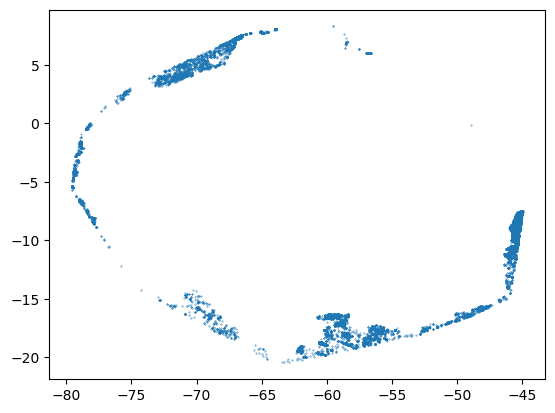

In [47]:
zeros = viirs[viirs.cover==0]
plt.scatter(zeros.longitude, zeros.latitude, s=0.1)

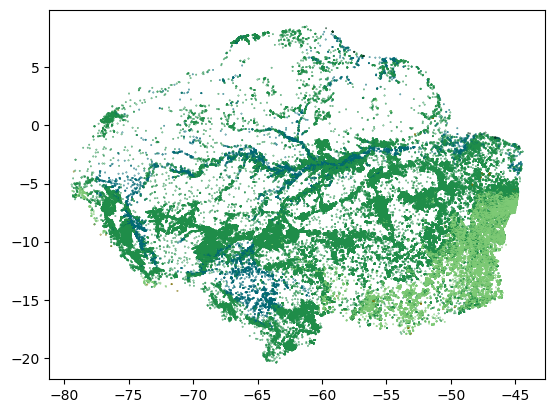

In [49]:
plt.scatter(viirs.longitude, viirs.latitude, c=viirs.color, s=0.1)

Text(0.5, 1.0, 'known detections')

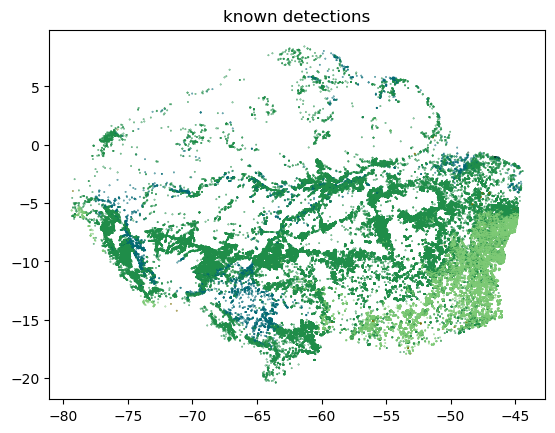

In [54]:
knowns = viirs[viirs.fire_mask > 6]
plt.scatter(knowns.longitude, knowns.latitude, c=knowns.color, s=0.1)
plt.title('known detections')

Text(0.5, 1.0, 'candidate detections')

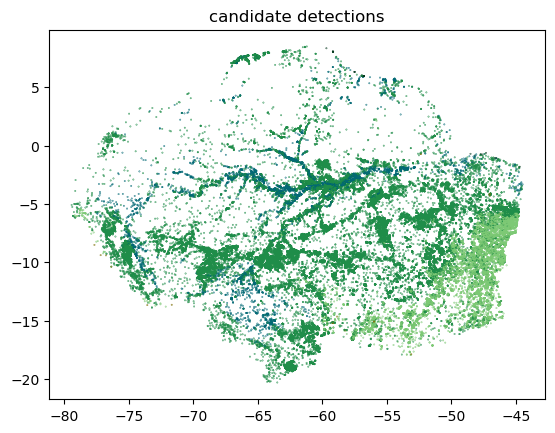

In [55]:
cands = viirs[viirs.fire_mask < 7]
plt.scatter(cands.longitude, cands.latitude, c=cands.color, s=0.1)
plt.title('candidate detections')